# Agent based modelling of social systems

### Modelling social awereness through a cognitive architecture model
Questions/Topics : 
* What is our question(clear formulation)-> Global awereness
* Topology of network
* Network generator (random?)
* Interaction of agents
* Literature
* Assumptions

### Structure
* Output: Plot Magnitude of event vs Importance of agent (color:fraction of agents, prob. to pass threshold)
* Model: 
 * P(k) distribution of #of outward lines
 * Interaction as a weighted relation of importance of agent and magnitude of event)
* Network: 
 * Random neighbour selection
 * % of neighbours interaction in each time step
* Events
 * Prob. distribution of events log(magn)= $\beta$ - $\gamma$log(occurences)
 * Decay as an exponential function
 * Global magnitude state of each event

In [1]:
import numpy as np
import igraph
import matplotlib.pyplot as plt
from IPython.display import *
% matplotlib inline

  

In [2]:
class SocialNet:
    def __init__(self, N):
        """
        Initialize the Graph with N number of agents and 
        give them a number of connections(links) from a 
        power law distribution -> scale-free network. Adjust 
        the size of each vertex to represent the number of
        links it has.
        """
        self.N = N        
        self.g = igraph.Graph(self.N )
        self._create_agents() 
        self._create_links()
        self.visual_style = {}
        self.visual_style["vertex_size"]=self.g.vs["size"]
        self.visual_style["edge_arrow_size"] = 0.5 
    
    
    def _create_agents(self):
        """Sets attributes of vertices in Graph g"""
        for v in self.g.vs:
            links = self.scale_free_distr()
            v["size"] = 5 + 2*links
            v["links"] = links
            v["open links"] = links
            if links > 5:
                v["type"] = "core"
                v["color"] = "slate blue"
            else:
                v["type"] = "peripheral"
                v["color"] = "SeaGreen2"                
        return
    
    def _create_links(self):        
        links = {}
        for v in self.g.vs.indices:
            links[v] = self.g.vs[v]['open links']
            
        L = self.g.vs.indices
        while len(L)>1:            
            newlink=np.random.choice(L,2)
            if links[newlink[0]]>1 and links[newlink[1]]>1:
                links[newlink[1]]-=1
                links[newlink[0]]-=1
            elif links[newlink[1]]==1:
                L = np.delete(L,np.where(L==newlink[1]))
            elif links[newlink[0]]==1:
                L = np.delete(L,np.where(L==newlink[0]))

            self.g.add_edge(newlink[0], newlink[1]) 
        return
        
    
    def scale_free_distr(self):
        """Power law distr P(k)=k^-2. In order to 
        limit the number of links possible distr is truncated
        at 0.001
        """
        p = np.random.rand()
        if p <= 0.001:
            return 1
        else:
            return int(np.round(1/np.sqrt(p)))
        
    def update(self):
        """Update all vertices by propagating the information and setting the new state"""
        pass
    
    def draw(self):        
        igraph.plot(self.g, "img/temp.png", **self.visual_style)
        display(Image(filename='img/temp.png')) 
        
    def displayPlot(self):
        plt.savefig("img/temp_plot.png")
        display(Image(filename='img/temp_plot.png'))

class Agent(igraph.Vertex):
    def __init__(self, name, num_links):
        self.attr = self.attributes()
        self.num_links = num_links
        self.visual_style["vertex_size"]=2*self.num_links
        self.visual_style["edge_arrow_size"] = 0.5
    def _create_links(self):
        pass
    def set_attributes(self):
        self.attr["size"] = int(self.num_links*2)        
        
        

            

In [4]:
Net = SocialNet(100)


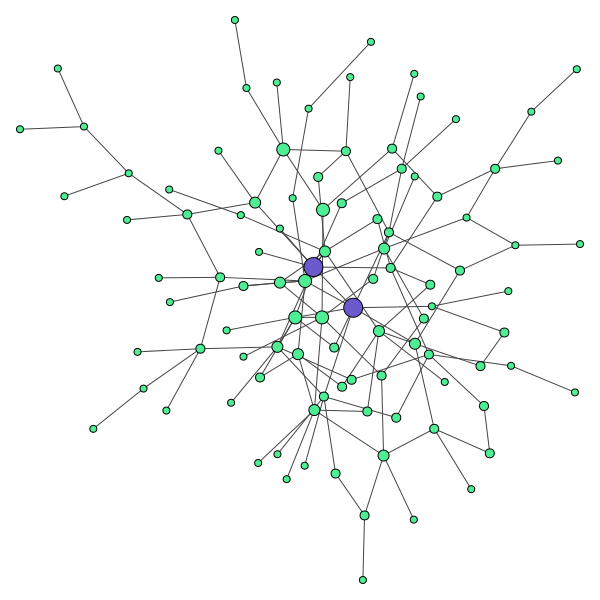

In [5]:
Net.g.simplify()   
Net.draw()

In [6]:
class AwerenessSimulation():
    def __init__(self, number_of_events, SocialNetwork):
        self.network = SocialNetwork
        self.event_weights = [1.0, 0.7, 0.3, 0.2, 0.4]
        self.events_table = ['emergency', 'political', 'sports', 'art', 'gossip']
        self.events = {}
        for i in range(len(self.events_table)):
            self.events[self.events_table[i]] = np.random.choice(np.arange(1,10, 1), 1)[-1]*self.event_weights[i]
        
        
    def generate_events(self):
        for e in range(self.num_events):
            event = SocialEvent()
            what = np.random.choice([range(len(event.event_types))], 1)[0]
            self.events_table.append(event)
    
    def initialize_events_in_network(self):
        for v in self.g.vs:
            v['event'] = self.events_table[-1]
            v['magnitude'] = np.random.choice(np.arange(1,10, 1), 1)[-1]*self.event_weights[-1]
            
class SocialEvent:
    def __init__(self):
        self.attributes = {'name':tag, 'magnitude':magnitude, 'time': 0}
        self.event_types = ['emergency', 'political', 'sports', 'art', 'gossip']
        self.event_weights = [1.0, 0.7, 0.3, 0.2, 0.4]
        
    def update_event(self):
        pass
    